In [1]:
import pandas as pd
dbdf = pd.read_csv('/content/Diabetes Database.csv')

In [2]:
dbdf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
print('Different attributes provided in the dataset to find which patients have diabeties are...')
print(dbdf.columns.values)

Different attributes provided in the dataset to find which patients have diabeties are...
['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI'
 'DiabetesPedigreeFunction' 'Age' 'Outcome']


In [4]:
# Here, Outcome value 0 means non-diabetic and 1 means diabetic
# Class distribution
dbdf.groupby(dbdf.columns[-1]).size()

Outcome
0    500
1    268
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


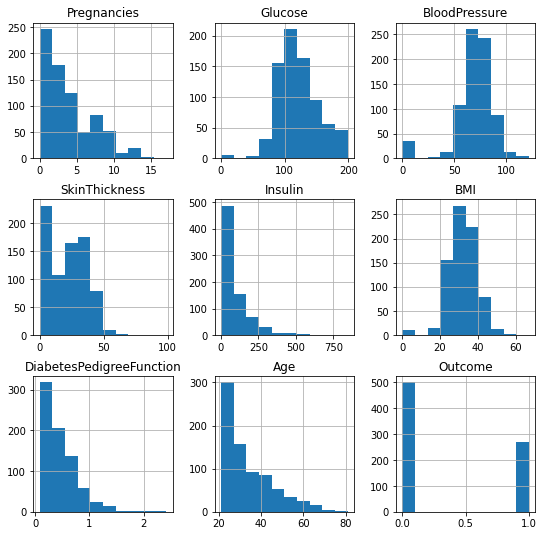

In [5]:
# Data distribution
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (9,9))
ax = fig.gca()
dbdf.hist(ax = ax)

plt.show()

OUTCOME - 0 (is 1st subplot) & OUTCOME - 1 (is 2nd subplot)


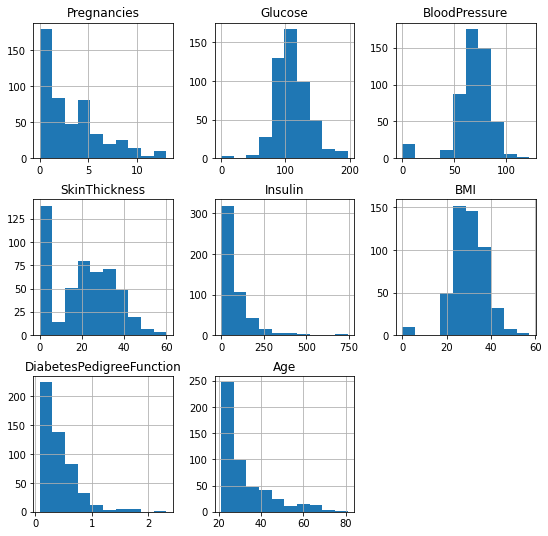

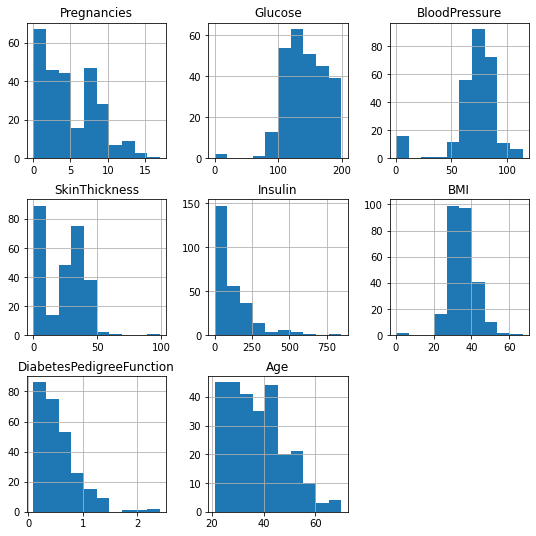

In [6]:
dbdf.groupby(dbdf.columns[-1]).hist(figsize = (9,9))
print('OUTCOME - 0 (is 1st subplot) & OUTCOME - 1 (is 2nd subplot)')

plt.show()

In [7]:
# Finding whether any missing values are present in the data
dbdf.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
# Finding whether any null values are present in the data
dbdf.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
# For diabetes dataset, possible outliers would be attributes value equals to zero. 
# So we would check whether attribute values are zero.

for i in range(1, len(dbdf.columns) - 3):
  if(len(dbdf.columns[i]) > 12):
    print('Total no. of rows having 0 in ',dbdf.columns[i],' is ',dbdf[dbdf[dbdf.columns[i]] == 0].shape[0])
  elif(len(dbdf.columns[i]) > 5):
    print('Total no. of rows having 0 in ',dbdf.columns[i],' is\t ',dbdf[dbdf[dbdf.columns[i]] == 0].shape[0])
  else:
    print('Total no. of rows having 0 in ',dbdf.columns[i],' is\t\t ',dbdf[dbdf[dbdf.columns[i]] == 0].shape[0])

Total no. of rows having 0 in  Glucose  is	  5
Total no. of rows having 0 in  BloodPressure  is  35
Total no. of rows having 0 in  SkinThickness  is  227
Total no. of rows having 0 in  Insulin  is	  374
Total no. of rows having 0 in  BMI  is		  11


In [10]:
# Since for SkinThickness and Insulin, Total values is large.
# It will not be a better option to remove those rows.
# So we try to remove the rows of atrribute Glucose, BloodPressure and BMI

mdf = dbdf[(dbdf.Glucose != 0) & (dbdf.BloodPressure != 0) & (dbdf.BMI != 0)]

In [11]:
X = mdf.iloc[:,:-1].values
y = mdf.iloc[:,-1].values.reshape(-1,1)

In [12]:
# Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


In [13]:
# Model selection

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [14]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

In [15]:
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")


names = []
scores = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)

tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.701657
1   LR  0.751381
2   DT  0.701657
3  GNB  0.734807
4   RF  0.734807


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

strat_k_fold = StratifiedKFold(n_splits=10, random_state=10)

names = []
scores = []

for name, model in models:
    
    score = cross_val_score(model, X, y, cv=strat_k_fold, scoring='accuracy').mean()
    names.append(name)
    scores.append(score)

kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

  Name     Score
0  KNN  0.714136
1   LR  0.763813
2   DT  0.688071
3  GNB  0.754205
4   RF  0.766743


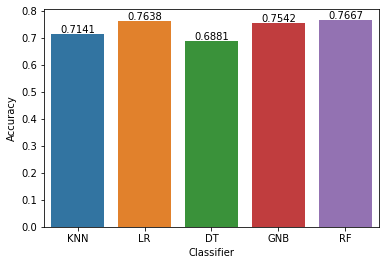

In [17]:
import seaborn as sns

axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

In [18]:
# Logistic regression and Random Forest have almost same accuracy for diabetes prediction.
# So let's try to build both the models from scratch and find which one give best result(in scratch).

import numpy as np

class LogitRegression():
    def __init__(self, learning_rate, iterations):
        self.learning_rate = learning_rate         
        self.iterations = iterations 
          
    # Function for model training     
    def fit(self, X, Y):
        # no_of_training_examples, no_of_features         
        self.m, self.n = X.shape
        # weight initialization
        self.W = np.zeros(self.n)
        self.b = 0
        self.X = X
        self.Y = Y
          
        # gradient descent learning 
                  
        for i in range(self.iterations):
            self.update_weights()
        return self
      
    # Helper function to update weights in gradient descent 
      
    def update_weights(self):
        A = 1 / (1 + np.exp(-(self.X.dot(self.W) + self.b)))
          
        # calculate gradients         
        tmp = (A - self.Y.T)         
        tmp = np.reshape(tmp, self.m)         
        dW = np.dot(self.X.T, tmp) / self.m          
        db = np.sum(tmp) / self.m  
          
        # update weights     
        self.W = self.W - self.learning_rate * dW     
        self.b = self.b - self.learning_rate * db 
          
        return self
      
    # Hypothetical function  h( x )  
      
    def predict(self, X) :     
        Z = 1 / (1 + np.exp(-(X.dot(self.W) + self.b)))         
        Y = np.where(Z > 0.5, 1, 0)
        return Y

model = LogitRegression(learning_rate = 0.02, iterations = 6000)
model.fit(X_train, y_train)
Y_pred = model.predict(X_test)

correctly_classified = 0
count = 0
for count in range(np.size(Y_pred)):
  if y_test[count] == Y_pred[count]:
    correctly_classified = correctly_classified + 1
  count = count + 1
LR_acc = np.round(correctly_classified/count,3)
print("Accuracy on test set by our model :",LR_acc)

Accuracy on test set by our model : 0.696


In [19]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [20]:
import math

model = RandomForest(X_train, y_train, n_trees=100, n_features='sqrt', sample_sz=len(X_train))#, depth=10, min_leaf=2)

In [21]:
preds = model.predict(X_test)

RF_acc = sum(preds == y_test)/len(y_test)
RF_acc = np.round(RF_acc[RF_acc != 0],3)
print("Testing accuracy: %.3f" %RF_acc[0])

Testing accuracy: 0.669


In [22]:
if RF_acc[0] > LR_acc:
  print("Random Forest is the best model with {}% accuracy for Diabetes prediction".format(RF_acc[0]*100))
elif RF_acc[0] < LR_acc:
  print("Logistic Regression is the best model with {}% accuracy for Diabetes prediction".format(LR_acc*100))
else:
  print("Both Logistic and Random forest are the best model with {}% accuracy for Diabetes prediction".format(LR*100))

Logistic Regression is the best model with 69.6% accuracy for Diabetes prediction
